In [2]:
%load_ext iminizinc

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns

import mplfinance as mpf
%matplotlib inline

mpl.rcParams.update({'font.size': 5, 'lines.linewidth': 0.5, 'figure.dpi': 300})
plt.rcParams['lines.linewidth'] = 0.5 



<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.7.4, build 863757726
Copyright (C) 2014-2023 Monash University, NICTA, Data61


In [3]:
odf = pd.read_json(r'../freq-user-data/data/binance/BTC_USDT-8h.json').dropna()
odf.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

odf['date'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=False)
odf['idate'] = odf.date.dt.strftime('%Y%m%d')
odf.set_index(pd.DatetimeIndex(odf["date"]), inplace=True, drop=True)
odf = odf.sort_index()
odf

,timestamp,open,high,low,close,volume,date,idate
date,,,,,,,,
2021-01-01 00:00:00,1609459200000,28923.63,29470.00,28690.17,29092.83,18869.366827,2021-01-01 00:00:00,20210101
2021-01-01 08:00:00,1609488000000,29092.84,29600.00,28872.24,29188.67,20078.654834,2021-01-01 08:00:00,20210101
2021-01-01 16:00:00,1609516800000,29188.67,29360.00,28624.57,29331.69,15234.903350,2021-01-01 16:00:00,20210101
2021-01-02 00:00:00,1609545600000,29331.70,29820.50,28946.53,29750.00,17258.671371,2021-01-02 00:00:00,20210102
2021-01-02 08:00:00,1609574400000,29751.47,31800.00,29473.91,31691.29,43255.778007,2021-01-02 08:00:00,20210102
...,...,...,...,...,...,...,...,...
2023-05-11 00:00:00,1683763200000,27598.74,27622.68,27367.76,27450.07,9819.590800,2023-05-11 00:00:00,20230511
2023-05-11 08:00:00,1683792000000,27450.07,27630.14,26952.00,27179.42,19518.716970,2023-05-11 08:00:00,20230511
2023-05-11 16:00:00,1683820800000,27179.43,27219.52,26702.05,26968.62,18297.005880,2023-05-11 16:00:00,20230511


In [ ]:
layout1 = cf.Layout(
    height=300,
    width=200
)
# print(matplotlib.pyplot.gcf())

fig = odf.figure()
# data=odf.figure()['data']


qf=cf.QuantFig(odf,title='Quant Figure',legend='top',name='GS' )
# qf.figure().axhline(20000)
qf.iplot(dimensions =(1500,500))

fig.add_hline(y=51000)
fig



## Last Swing Low -> Swing High 

In [138]:
df = odf['2023-02-01':]

kl_n = len(df)
kl_close = df.close.astype(int).tolist()
kl_idate = df.idate.to_list()
inow = df.shape[0] 
model_params = {'kl_n': kl_n, 'kl_close': kl_close, 'kl_idate': kl_idate, 'inow': inow}
with open('swing_high.json', 'w+') as f:
    f.write(json.dumps(model_params, indent=0))
    # f.write(f'kl_n = {len(df)};\n')
    # f.write(f'kl_signal = [' + ', '.join(df.close.astype(int).astype(str)) + '];\n')
# kl_idate

In [161]:
from minizinc import Instance, Model, Solver
import nest_asyncio
nest_asyncio.apply()

swing_high = Model("./swing_high.mzn")
# Find the MiniZinc solver configuration for Gecode
gecode = Solver.lookup("gecode")
# Create an Instance of the n-Queens model for Gecode
instance = Instance(gecode, swing_high)

for k,v in model_params.items(): instance[k] = v
    # print(k,v)
# instance["n"] = 4
result = instance.solve()
# # Output the array q
print(result)

Solution(objective=232, ipeak_0=217, ipeak_1=70, itrough_0=115, obj=232, _checker='')


In [120]:
%%minizinc -m bind

array[int] of int: kl_close;

int: kl_n;
set of int: KLN = 1..kl_n;
int: inow;
var int: ipeak_0;
var int: ipeak_1;
var int: itrough_0;

array[1..4] of var int: apktr = [ipeak_1, itrough_0, ipeak_0, inow];

constraint forall(k in apktr) (k >= 1 /\ k <= kl_n);
constraint forall(i in 1..3)(apktr[i+1] - apktr[i] > 3 * 7 * 2);
include "increasing.mzn";
constraint increasing([ipeak_1, itrough_0, ipeak_0]);
include "all_different.mzn";
constraint all_different([ipeak_1, itrough_0, ipeak_0]);
constraint forall(i in itrough_0..ipeak_0)(kl_close[i] >= kl_close[itrough_0] /\ kl_close[i] <= kl_close[ipeak_0]);
constraint forall(i in ipeak_1..itrough_0)(kl_close[i] >= kl_close[itrough_0] /\ kl_close[i] <= kl_close[ipeak_1]);
constraint forall(i in ipeak_0..inow)(kl_close[i] <= kl_close[ipeak_0]);
constraint kl_close[ipeak_0] >= kl_close[ipeak_1];

var int: obj;
constraint obj = inow - ipeak_1;


solve minimize obj;

In [85]:
import mplfinance as fplt
from minizinc import Instance, Model, Solver
import nest_asyncio
nest_asyncio.apply()

fibs = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

dlen = len(odf)

kl_n, kl_close, kl_idate, inow = None,None,None,None
ipeak_1, itrough_0, ipeak_0 = None, None, None
wdf = None

# sl_start= IntSlider(description="Str", min=0, max=dlen, step=10, value=dlen-200)
# sl_end = IntSlider(description="End", min=0, max=dlen, value=dlen, step=10)
sl_range = IntRangeSlider(
    value=[int(dlen-1000), dlen],
    min=0,
    max=dlen,
    step=50,
    description='Rng',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
sl_now = IntSlider(description="Now", min=0, max=dlen, value=dlen, step=50)

# def change_end(val):
#     sl_start.value = sl_end.value - 700
#     sl_end.observe(change_end, 'value')

def range_changed(v):
    wstart, wend = sl_range.value
    sl_now.max = wend-wstart
    # print('Calc wdf.shape: ', wdf.shape)


sl_range.observe(range_changed, 'value')

ui = widgets.VBox([VBox([sl_range, sl_now])])
# wstart, wend
def printer(wrange, inow):
    global kl_n, kl_close, kl_idate
    global ipeak_1, itrough_0, ipeak_0
    global wdf

    wstart, wend = sl_range.value
    wdf = odf.iloc[wstart:wend, :]
    print('inow=',inow)
    if wdf is None: return
    # wdf = odf.iloc[wstart:wend, :]

    kl_n = wdf.shape[0]
    kl_close = wdf.close.astype(int).tolist()
    kl_idate = wdf.idate.to_list()
    
    model_params = {'kl_n': kl_n, 'inow': inow, 'kl_close': kl_close}
    with open('swing_high.json', 'w+') as f: f.write(json.dumps(model_params, indent=0))

    # print('Model params:', model_params)
    swing_high = Model("./swing_high.mzn")
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, swing_high)

    # instance.branch()
    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()

    print(result)
    i_1, i_2, i_3, obj = resarr = [result['i_1'],result['i_2'],result['i_3'],result['obj']]

    swing_low, swing_high = kl_close[i_2-1], kl_close[i_3-1]
    fib_levels = [swing_low + f*(swing_high-swing_low) for f in fibs]
    # %minizinc swing_high kl_n=kl_n
    
    s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 8})
    fig = mpf.figure(figsize=(15, 4), style=s) # pass in the self defined style to the whole canvas
    ax = fig.add_subplot(1,1,1) # main candle stick chart subplot, you can also pass in the self defined style here only for this subplot
    # av = fig.add_subplot(2,1,2, sharex=ax)  # volume chart subplot
    # wdf.close.plot(ax=ax, lw=1)

    ################################
    # ax.plot(wdf.close, lw=1)
    # ax.axvline(wdf.index[inow-1], c='b', lw=0.7)
    # ax.axvline(wdf.index[i_1-1], c='g', lw=0.7)
    # ax.axvline(wdf.index[i_3-1], c='g', lw=0.7)
    # ax.axvline(wdf.index[i_2-1], c='r', lw=0.7)
    # ax.hlines(fib_levels, wdf.index[i_2-1], wdf.index[inow-1], lw=0.5)

    ################################
    # for f in fibs:
    #     l = swing_low + f*(swing_high-swing_low)
        

    # for v in [ipeak_0, ipeak_1, itrough_0]: ax.axvline(v-1, lw=0.7)
    ####################
    mpf.plot(wdf, type='candle', ax=ax)
    ax.axvline(inow-1, c='b', lw=0.7)
    # ax.axvline(i_1-1, c='g', lw=0.7)
    ax.axvline(i_3-1, c='g', lw=0.7)
    ax.axvline(i_2-1, c='r', lw=0.7)
    ax.hlines(fib_levels, i_2-1, inow-1, lw=0.5)

out = widgets.interactive_output(printer, {'wrange': sl_range, 'inow': sl_now})
display(ui, out)


Output()

### FInd all swing-low-->swing-highs and fib levels

In [84]:
from minizinc import Instance, Model, Solver
import nest_asyncio
nest_asyncio.apply()
%matplotlib inline
# %matplotlib

strategy = 'all-swing_highs'
strategy_params_json = f'./strategy-params/{strategy}.json'

fibs = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

dlen = len(odf)

kl_n, kl_close, kl_idate, inow = None,None,None,None
idxs = None
wdf = None

sl_range = IntRangeSlider(
    value=[int(dlen-1000), dlen],
    min=0,
    max=dlen,
    step=100,
    description='Rng',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
# sl_now = IntSlider(description="Now", min=0, max=dlen, value=dlen, step=50)

# def range_changed(v):
#     wstart, wend = sl_range.value
#     sl_now.max = wend-wstart

# sl_range.observe(range_changed, 'value')
strategy_params = {}
strategy_params = {"wrange": {'wdg': sl_range}, **strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])
# ui = widgets.VBox([VBox([sl_range, sl_now])])
idxs, nsn, lha = None, None, None
def printer(wrange):
    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))
    global kl_n, kl_close, kl_idate
    global idxs, nsn, lha
    global wdf
    wstart, wend = sl_range.value

    print('Length: ', wend - wstart + 1)

    wdf = odf.iloc[wstart:wend, :]
    if wdf is None: return
    # wdf = odf.iloc[wstart:wend, :]

    kl_close = wdf.close.astype(int).values
    
    ################################
    ### Call Minizinc solver
    ##------------------------------

    model_params = {'ser_n': len(kl_close), 'series': kl_close.tolist()}
    with open('all-swing_highs.json', 'w+') as f: f.write(json.dumps(model_params, indent=0))

    #######

    # print('Model params:', model_params)

    swing_high = Model("./all-swing_highs.mzn")
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, swing_high)

    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()
    with open('all-swing_highs-result.json', 'w+') as f: f.write(json.dumps({'lha': result['lha'], 'nsn': result['nsn']}))


    # with open('all-swing_highs-result.json') as f: result = json.loads(f.read())

    lha, nsn = resarr = [result['lha'],result['nsn']]
    print(f'nsn={nsn}\nlha=\n{lha[0]}\n{lha[1]}')

    # ##############################################################
    # i_1 = [1, 37, 75, 118, 162, 207, 244, 285, 285, 285, 285, 285, 285, 285]
    # i_2 = [21, 57, 98, 147, 169, 223, 254, 285, 285, 285, 285, 285, 285, 285]
    # i_3 = [30, 68, 108, 155, 200, 237, 265, 285, 285, 285, 285, 285, 285, 285]
    # i_4 = [37, 75, 115, 162, 207, 244, 272, 285, 285, 285, 285, 285, 285, 285]
    # idxs = [
    #     [   1,   3,  15],
    #     [  15,  16,  29],
    #     [  29,  42,  43],
    #     [  43,  46,  57],
    #     [  57,  71,  71],
    #     [  71,  74,  85],
    #     [  85,  89,  99],
    #     [  99, 113, 113],
    # ]
    # nsn = len(idxs)
    # ##############################################################

    # idxs = [np.array(a) - 1 for a in idxs]
    # nsn = 2
    # lha = [
    #     [ 1, 274, 285 ],
    #     [ 4, 73, 285 ],    
    # ]

    idxs = (np.array(lha) - 1).T.tolist()
    # ##############################################################
    
    # s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 8})
    # fig = mpf.figure(figsize=(15, 4), style=s) # pass in the self defined style to the whole canvas
    # plt.clf()
    # plt.rcParams['figure.figsize'] = [9,5]
    fig = plt.figure(figsize=(9, 5))
    # ax = fig.add_subplot(1,1,1) # main candle stick chart subplot, you can also pass in the self defined style here only for this subplot


    ###############################
    plt.plot(wdf.close, lw=0.5)
    for i in range(nsn):
        r = idxs[i]
        x = wdf.index[r]
        y = kl_close[r]
        sw_l, sw_h = kl_close[r[0]], kl_close[r[1]]
        plt.vlines(wdf.index[r], ymin=sw_l, ymax=sw_h, lw=0.7, colors=['gray', 'green', 'red', 'blue'])
        plt.hlines([sw_l, sw_h], xmin=wdf.index[r[0]], xmax=wdf.index[r[1]], lw=0.7, colors='gray')
        plt.plot(x,y, c='g', lw=0.5)
        # plt.plot[]
        # ax.axvline(wdf.index[idxs[i][0]], c='g', lw=0.7)
        # ax.axvline(wdf.index[idxs[i][1]], c='r', lw=0.7)
        # ax.axvline(wdf.index[idxs[i][2]], c='g', lw=0.7)
        # ax.axvline(wdf.index[idxs[i][3]], c='b', lw=0.7)
        # ax.axvline(wdf.index[idxs[i][0]], c='g', lw=0.7)
        # ax.axvline(wdf.index[idxs[i][1]], c='r', lw=0.7)
        # ax.axvline(wdf.index[idxs[i][2]], c='g', lw=0.7)

    # ax.axvline(wdf.index[inow-1], c='b', lw=0.7)
    # ax.axvline(wdf.index[i_1-1], c='g', lw=0.7)
    # ax.axvline(wdf.index[i_3-1], c='g', lw=0.7)
    # ax.axvline(wdf.index[i_2-1], c='r', lw=0.7)
    # ax.hlines(fib_levels, wdf.index[i_2-1], wdf.index[inow-1], lw=0.5)

    ################################
    ################################
    ################################
    # mpf.plot(wdf, type='candle', ax=ax)
    # ax.axvline(inow-1, c='b', lw=0.7)
    # # ax.axvline(i_1-1, c='g', lw=0.7)
    # ax.axvline(i_3-1, c='g', lw=0.7)
    # ax.axvline(i_2-1, c='r', lw=0.7)
    # ax.hlines(fib_levels, i_2-1, inow-1, lw=0.5)

    plt.show();
    
if os.path.exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in strategy_params.items(): 
            if k in js: v['wdg'].value=js[k];

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()});
x = display(ui, out);
plt.close()
# fig

Output()

### Explore ranges

In [ ]:
odf = pd.read_json(r'../freq-user-data/data/binance/BTC_USDT-4h.json').dropna()
odf.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

odf['date'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=False)
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
odf['idate'] = odf.date.dt.strftime('%Y%m%d')
odf.set_index(pd.DatetimeIndex(odf["date"]), inplace=True, drop=True)
# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')
odf = odf.sort_index()
odf

In [7]:
from minizinc import Instance, Model, Solver, Status

import nest_asyncio
nest_asyncio.apply()

strategy = 'ranges'
strategy_params_json = f'./strategy-params/{strategy}.json'


fibs = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

mpl.rcParams.update({'font.size': 3, 'lines.linewidth': 0.5, 'figure.dpi': 300})
dlen = len(odf)

sl_range = IntRangeSlider(value=[int(dlen-1000), dlen],min=0,max=dlen,step=50,description='Rng',continuous_update=False)
sl_box = IntRangeSlider(value=[5, 10],min=1,max=50,step=1,description='Box',continuous_update=False)
# sl_lr = IntRangeSlider(value=[5, 10],min=1,max=50,step=1,description='Box',continuous_update=False)
sl_vola = IntRangeSlider(value=[50, 100],min=0,max=200,step=5,description='Vola',continuous_update=False)

strategy_params = {
    "box": {'wdg': sl_box},
    "vola": {'wdg': sl_vola}
}
strategy_params = {"wrange": {'wdg': sl_range}, **strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])

wdf = None
bmin, bmax = None, None
vmin, vmax = None, None
result = None
rstart, rend = None, None
def printer(wrange, box, vola):
    global wdf
    global bmin, bmax, vmin, vmax
    global result, rstart, rend
    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))
    
    wstart, wend = wrange
    bmin, bmax = box
    vmin, vmax = vola

    wdf = odf.iloc[wstart:wend, :].copy()

    print(f'N={len(wdf)}\n')


    wdf['lclmin'] = wdf.close.rolling(bmin).min()
    wdf['lclmax'] = wdf.close.rolling(bmin).max()
    wdf = wdf.dropna()
    wdf['brng'] = ((wdf.lclmax / wdf.lclmin - 1) * 1000).astype(int)
    
    wdf['idx'] = range(len(wdf))
    wdf['inrange'] = (wdf.brng >= vmin) & (wdf.brng <= vmax)

    # fl_rng_rstart = wdf.inrange & ~wdf.inrange.shift().fillna(False)

    # rstart = wdf[fl_rng_rstart].idx.values

    ################################
    ### Call Minizinc solver
    ##------------------------------

    model_params = {
        'bmin': bmin, 
        'bmax': bmax,
        'nfl': len(wdf),
        # 'nst' : len(rstart),
        # 'start': (rstart + 1).tolist(), 
        'flags': wdf.inrange.astype(int).tolist()
        }
    with open(f'{strategy}-dzn.json', 'w+') as f: f.write(json.dumps(model_params, indent=4))

    #######

    # print('Model params:', model_params)

    mzmodel = Model("./ranges.mzn")
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, mzmodel)

    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()
    print(result.status)

    rstart, rend = None, None
    arymin, arymax = None, None
    if result.status != Status.UNSATISFIABLE:
        # [srstart, srend] =  [result['srstart'], result['srend']]
        rstart, rend = list(map(lambda s: sorted(list(map(int, s.split(',')))), result['_output_item'].replace('sres=[{', '').replace('}]', '').split('}, {')))

        rstart = np.array(rstart) - 1
        rend = np.array(rend) - 1
        arymin = [wdf.iloc[rstart[i]:rend[i]].close.min() for i in list(range(len(rstart)))]
        arymax = [wdf.iloc[rstart[i]:rend[i]].close.max() for i in list(range(len(rstart)))]
    print(f'rstart={rstart}\nrend={rend}\n')

    fig = plt.figure(figsize=(9,5))
    ax1 = fig.add_subplot(2,1,1)
    # f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3,1]})

    # ax = fig.add_subplot(2,1,1)
    arxmin = wdf.index[rstart]
    arxmax = wdf.index[rend]
    rfibs = [ 
        round(lmin + f*(lmax-lmin) ) for f in fibs
        for lmin,lmax in [
            [wdf.lclmin.values[rstart[i]], wdf.lclmax.values[rstart[i]]]
            for i in range(len(rstart))
        ]
    ]
    fibxmin = wdf.index[rstart.tolist() * len(fibs)]
    fibxmax = wdf.index[rend.tolist() * len(fibs)]
    
    wdf.close.plot(ax=ax1)
    # ax1.vlines(wdf.index[rstart], ymin=arymin, ymax=arymax, colors='red', lw=0.5)
    # ax1.vlines(wdf.index[rend], ymin=arymin, ymax=arymax, colors='red', lw=0.5)
    for v in wdf.index[rstart]: ax1.axvline(v, c='green', lw=0.4, linestyle='--')
    for v in wdf.index[rend]: ax1.axvline(v, c='green', lw=0.4, linestyle='--')
    # ax1.hlines(arymin, xmin=arxmin, xmax=arxmax , colors='orange', lw=0.2)
    # ax1.hlines(arymax, xmin=arxmin, xmax=arxmax , colors='orange', lw=0.2)
    ax1.hlines(wdf.lclmin.values[rstart], xmin=arxmin, xmax=arxmax , colors='green', lw=0.7, linestyles='--')
    ax1.hlines(wdf.lclmax.values[rstart], xmin=arxmin, xmax=arxmax , colors='green', lw=0.7, linestyles='--')
    wdf.lclmin.plot(lw=0.1, c='g', ax=ax1)
    wdf.lclmax.plot(lw=0.1, c='r', ax=ax1)
    ax1.hlines(rfibs, xmin=fibxmin, xmax=fibxmax, colors='gray', lw=0.4, linestyles='--')
    # wdf.brng.plot(ax=ax1, secondary_y=True, lw=0.07, c='maroon')
    # plt.grid()

    # plt.show();
    
if os.path.exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in strategy_params.items(): 
            if k in js: v['wdg'].value=js[k];

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()});
x = display(ui, out);
plt.close()
# fig

Output()

### Rolling peaks

In [222]:
odf = pd.read_json(r'../freq-user-data/data/binance/BTC_USDT-2h.json').dropna()
odf.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

odf['date'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=False)
odf['idate'] = odf.date.dt.strftime('%Y%m%d')
odf.set_index(pd.DatetimeIndex(odf["date"]), inplace=True, drop=True)
odf = odf.sort_index()
odf

,timestamp,open,high,low,close,volume,date,idate
date,,,,,,,,
2021-01-01 00:00:00,1609459200000,28923.63,29470.00,28690.17,29409.99,7714.879916,2021-01-01 00:00:00,20210101
2021-01-01 02:00:00,1609466400000,29410.00,29465.26,29120.03,29278.40,3845.576637,2021-01-01 02:00:00,20210101
2021-01-01 04:00:00,1609473600000,29278.41,29395.00,29029.40,29187.01,3508.003065,2021-01-01 04:00:00,20210101
2021-01-01 06:00:00,1609480800000,29187.01,29270.00,28806.54,29092.83,3800.907209,2021-01-01 06:00:00,20210101
2021-01-01 08:00:00,1609488000000,29092.84,29307.73,28872.24,29202.21,4030.221761,2021-01-01 08:00:00,20210101
...,...,...,...,...,...,...,...,...
2023-05-12 12:00:00,1683892800000,26348.02,26556.96,26324.02,26450.00,4447.389650,2023-05-12 12:00:00,20230512
2023-05-12 14:00:00,1683900000000,26450.00,26614.67,26271.65,26320.84,6020.505710,2023-05-12 14:00:00,20230512
2023-05-12 16:00:00,1683907200000,26320.83,26408.19,26241.07,26304.49,3714.866460,2023-05-12 16:00:00,20230512


In [145]:
def runmodel(modelname, model_params):
    with open(f'{modelname}-dzn.json', 'w+') as f: f.write(json.dumps(model_params, indent=4))
    mzmodel = Model(f"./{strategy}.mzn")
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, mzmodel)

    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()
    return result;


In [277]:
idf = None
def gen_signal(wdf, params=None):
    global idf
    idf = pd.DataFrame(index=wdf.index)
    # lag, hold, pkmin, pkmax = 
    idf['lmin'] = wdf.close.rolling(params['lag']).min()
    idf['lmax'] = wdf.close.rolling(params['lag']).max()
    idf['lret'] = (wdf.close/wdf.close.shift()).apply(np.log)
    idf['flretmax'] = idf.lret.rolling(window=params['hold']).sum().rolling(params['hold']).max().shift(-params['hold'])
    idf['flretmin'] = idf.lret.rolling(window=params['hold']).sum().rolling(params['hold']).min().shift(-params['hold'])
    idf['fcmax'] = wdf.close.rolling(window=params['hold']).max().shift(-params['hold'])
    idf['fcmin'] = wdf.close.rolling(window=params['hold']).min().shift(-params['hold'])
    idf['fhhmax'] = wdf.high.rolling(window=params['hold']).max().shift(-params['hold'])
    idf['fllmin'] = wdf.low.rolling(window=params['hold']).min().shift(-params['hold'])
    idf['fhhlret'] = (idf.fhhmax / wdf.close).apply(np.log)
    idf['flllret'] = (idf.fllmin / wdf.close).apply(np.log)

    idf = idf.dropna()
    
    # wdf['idx'] = range(len(wdf))

    result = runmodel(strategy, model_params={
        'n': len(idf),
        'lag': params['lag'], 
        # 'lmin': wdf.lmin.astype(int).tolist(),
        'ser': idf.lmin.astype(int).tolist(),
        })
    print(result.status)
    #######
    idf['entries'] = 0
    idf['exits'] = 0
    flretmax, flretmin = [], []
    sig = []
    mod_res = ['dirx','cdirx','durx']
    for x in mod_res: idf[ x] = pd.NA
    if result.status == Status.SATISFIED:
        for x in mod_res: idf[ x] = result[x]
        
        entries =( 
            (idf.cdirx >= params['pkmin']) & 
            (idf.cdirx <= params['pkmax']) &
            (idf.durx == 1)
        );
        entries = entries & ((~entries).shift())

        idf['entries'] = entries

    return idf

stra_params = {'lag': 10, 'hold': 24, 'pkmin': -8, 'pkmax': -1}
gen_signal(wdf, stra_params)

UNSATISFIABLE


/home/grenada/miniconda3/envs/py311/lib/python3.11/site-packages/minizinc/json.py:108: MiniZincWarning: model inconsistency detected
  warnings.warn(obj["message"], MiniZincWarning)


,lmin,lmax,lret,flretmax,flretmin,fcmax,fcmin,fhhmax,fllmin,fhhlret,flllret,entries,exits,dirx,cdirx,durx
date,,,,,,,,,,,,,,,,
2023-01-30 18:00:00,22784.86,23728.71,-0.014123,0.026041,-0.036181,23385.99,22743.70,23494.77,22500.00,0.030682,-0.012581,0,0,NaN,NaN,NaN
2023-01-30 20:00:00,22743.70,23728.71,-0.001808,0.040387,-0.036181,23681.05,22759.14,23800.00,22500.00,0.045397,-0.010773,0,0,NaN,NaN,NaN
2023-01-30 22:00:00,22743.70,23728.71,0.003619,0.040387,-0.036181,23732.66,22759.14,23812.66,22714.77,0.042311,-0.004891,0,0,NaN,NaN,NaN
2023-01-31 00:00:00,22743.70,23642.81,0.000179,0.047906,-0.036181,23950.55,22759.14,24255.00,22743.05,0.060537,-0.003826,0,0,NaN,NaN,NaN
2023-01-31 02:00:00,22743.70,23191.20,0.000209,0.047906,-0.036181,23950.55,22759.14,24255.00,22743.05,0.060328,-0.004035,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-10 12:00:00,27542.26,28169.76,0.017644,0.012776,-0.062993,28153.20,26276.67,28299.15,26120.74,0.004583,-0.075519,0,0,NaN,NaN,NaN
2023-05-10 14:00:00,27542.26,28169.76,-0.000588,0.012776,-0.067300,27692.26,26276.67,28299.15,26120.74,0.005171,-0.074931,0,0,NaN,NaN,NaN
2023-05-10 16:00:00,27498.72,28169.76,-0.023522,0.012776,-0.067300,27692.26,26276.67,27982.23,26120.74,0.017430,-0.051410,0,0,NaN,NaN,NaN


In [278]:
idf

,lmin,lmax,lret,flretmax,flretmin,fcmax,fcmin,fhhmax,fllmin,fhhlret,flllret,entries,exits,dirx,cdirx,durx
date,,,,,,,,,,,,,,,,
2023-01-30 18:00:00,22784.86,23728.71,-0.014123,0.026041,-0.036181,23385.99,22743.70,23494.77,22500.00,0.030682,-0.012581,0,0,NaN,NaN,NaN
2023-01-30 20:00:00,22743.70,23728.71,-0.001808,0.040387,-0.036181,23681.05,22759.14,23800.00,22500.00,0.045397,-0.010773,0,0,NaN,NaN,NaN
2023-01-30 22:00:00,22743.70,23728.71,0.003619,0.040387,-0.036181,23732.66,22759.14,23812.66,22714.77,0.042311,-0.004891,0,0,NaN,NaN,NaN
2023-01-31 00:00:00,22743.70,23642.81,0.000179,0.047906,-0.036181,23950.55,22759.14,24255.00,22743.05,0.060537,-0.003826,0,0,NaN,NaN,NaN
2023-01-31 02:00:00,22743.70,23191.20,0.000209,0.047906,-0.036181,23950.55,22759.14,24255.00,22743.05,0.060328,-0.004035,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-10 12:00:00,27542.26,28169.76,0.017644,0.012776,-0.062993,28153.20,26276.67,28299.15,26120.74,0.004583,-0.075519,0,0,NaN,NaN,NaN
2023-05-10 14:00:00,27542.26,28169.76,-0.000588,0.012776,-0.067300,27692.26,26276.67,28299.15,26120.74,0.005171,-0.074931,0,0,NaN,NaN,NaN
2023-05-10 16:00:00,27498.72,28169.76,-0.023522,0.012776,-0.067300,27692.26,26276.67,27982.23,26120.74,0.017430,-0.051410,0,0,NaN,NaN,NaN


In [380]:
### Rolling peaks

from minizinc import Instance, Model, Solver, Status

import nest_asyncio
nest_asyncio.apply()

strategy = 'rolling-peaks'
strategy_params_json = f'./strategy-params/{strategy}.json'

mpl.rcParams.update({'font.size': 3, 'lines.linewidth': 0.5, 'figure.dpi': 300})
dlen = len(odf)

sl_range = IntRangeSlider(value=[int(dlen-1000), dlen],min=0,max=dlen,step=10,description='Rng',continuous_update=False)
sl_lag = IntSlider(value=30,min=1,max=100,step=1,description='Lag',continuous_update=False)
sl_hold = IntSlider(value=30,min=1,max=100,step=1,description='Hold',continuous_update=False)
sl_peaks = IntRangeSlider(value=[-5, 0],min=-10,max=10,step=1,description='Peaks',continuous_update=False)
# sl_vola = IntRangeSlider(value=[50, 100],min=0,max=200,step=5,description='Vola',continuous_update=False)

strategy_params = {
    "lag": {'wdg': sl_lag},
    "hold": {'wdg': sl_hold},
    "peaks": {'wdg': sl_peaks}
}
strategy_params = {"wrange": {'wdg': sl_range}, **strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])

wdf = None
result = None
flretmax, flretmin = [],[]
def printer(wrange, lag, hold, peaks):
    global wdf
    global bmin, bmax, dmax, cdmax, pkmin, pkmax
    global result
    global flretmax, flretmin
    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))
    
    wstart, wend = wrange
    pkmin, pkmax = peaks
    wdf = odf.iloc[wstart:wend, :].copy()

    print(f'N={len(wdf)}, Period: {wdf.index[-1] - wdf.index[0]}, Start: {wdf.index[0]}, End: {wdf.index[-1]}\n')


    stra_params = {'lag': lag, 'hold': hold, 'pkmin': pkmin, 'pkmax': pkmax}
    # print(stra_params)
    # idf = gen_signal(wdf, params=stra_params)

    # entries = idf.entries;
    # flretmax = idf.fhhlret[entries]
    # flretmin = idf.flllret[entries]

    # # widx = wdf.index.values
    # sigidx = idf.index[entries]

    fig = plt.figure(layout="constrained", figsize=(9,4))
    [fig1,fig2] = fig.subfigures(1, 2, wspace=0.07, hspace=0., width_ratios=[5, 2])
    # fig1.set_facecolor('0.9')

    (ax1,ax2) = fig1.subplots(2, 1, height_ratios=[3,1])


    # (axR1, axR2, axR3, axR4) = fig2.subplots(4, 1)

    
    ax1.plot(wdf.close)
    # idf.fhhmax.plot(ax=ax1,lw=0.2, c='g', style='--')
    # idf.fllmin.plot(ax=ax1,lw=0.2, c='r', style='--')
    # idf.lmin.plot(lw=0.3, c='g', ax=ax1)
    # idf.lmax.plot(lw=0.3, c='r', ax=ax1)
    # # ax1s = ax1.secondary_yaxis('right')
    # idf.cdirx.plot(ax=ax2, sharex=ax1)
    
    # wdf.fcmax.plot(ax=ax1,lw=0.2, c='m')
    # wdf.flretmax.plot(ax=ax2, c='g')
    # wdf.flretmin.plot(ax=ax2, c='r')

    # print(f'Signals: {len(sigidx)}')
    # for s in sigidx:
    #     ax1.axvline(s)

    # axR1.axhline(0.5)
    # ax2.axhline(0)
    # sns.kdeplot(data=flretmax, ax=axR1, color='g', cumulative=True, clip=(-0.1,0.1))
    # sns.kdeplot(data=flretmin.abs(), ax=axR1, color='r', cumulative=True, clip=(-0.1,0.1))
    plt.show()
    
if os.path.exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in strategy_params.items(): 
            if k in js: v['wdg'].value=js[k];

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()});
x = display(ui, out);
plt.close()
# fig

Output()

In [493]:
wnd = 500
jmp = 100
stra_params = {'lag': sl_lag.value, 'hold': sl_hold.value, 'pkmin': sl_peaks.value[0], 'pkmax': sl_peaks.value[1]}

# def analyze_trades(wdf, entries=[] hold_periods=[]):
idf['e'] = wdf.close.ewm(span=50).mean()

entries=(wdf.close < idf.e) & (wdf.close.shift() > idf.e)
hold_periods=[6, 12, 24]

# fig = plt.figure(layout="constrained", figsize=(9,4))
# ax = wdf.close.plot(figsize=(9,3))
# idf.plot(ax=ax)
# for x in wdf.index[entries]:
#     ax.axvline(x)

# pd.DataFrame.from_dict(
{
    **{
        {
            **{(ho, 'l', i) : wdf.close.divide(wdf.low[entries].rolling(ho).min().shift(-ho)).apply(np.log).describe() for ho in hold_periods },
            **{(ho, 'h', i) : wdf.close.divide(wdf.high[entries].rolling(ho).max().shift(-ho)).apply(np.log).describe() for ho in hold_periods }
        }
        for (i,df) in 
        [ (i,odf.iloc[i:i+wnd]) for i in [s * jmp for s in range((odf.shape[0] - wnd) // jmp + 1)] ]
    }
}
# )
# for i in [s * jmp for s in range((odf.shape[0] - wnd) // jmp + 1)] 

    

# tdf.describe()
# ho=9
# wdf.close.divide(wdf.low[entries].rolling(ho).min().shift(-ho)).apply(np.log).describe()
# (wdf.close / wdf.low[entries].rolling(ho).min().shift(-ho)).apply(np.log)
# sdfs = 
# [
#     df
#     for (i,df) in 
#     [ (i,odf.iloc[i:i+wnd]) for i in [s * jmp for s in range((odf.shape[0] - wnd) // jmp + 1)] ]
# ]
# Based on the entries, analyse max and min future values for different time periods


[{(6,
   'l',
   0): count    64.000000
  mean      0.025477
  std       0.070103
  min      -0.210833
  25%       0.002689
  50%       0.010725
  75%       0.018960
  max       0.230478
  dtype: float64,
  (12,
   'l',
   0): count    58.000000
  mean      0.047244
  std       0.082953
  min      -0.210833
  25%       0.008253
  50%       0.016420
  75%       0.050511
  max       0.245923
  dtype: float64,
  (24,
   'l',
   0): count    46.000000
  mean      0.094117
  std       0.088490
  min      -0.009424
  25%       0.018761
  50%       0.031917
  75%       0.164357
  max       0.247477
  dtype: float64,
  (6,
   'h',
   0): count    64.000000
  mean     -0.050727
  std       0.089345
  min      -0.346809
  25%      -0.051835
  50%      -0.032182
  75%      -0.004540
  max       0.206428
  dtype: float64,
  (12,
   'h',
   0): count    58.000000
  mean     -0.100778
  std       0.121999
  min      -0.357209
  25%      -0.100456
  50%      -0.064111
  75%      -0.026803
  max      

In [365]:
# adf = pd.DataFrame([f.fhhlret.describe() for f in sdfs] )
# # adf['50%'].plot()
# sdfs
# ddf = pd.DataFrame(
#     [
#         df[df.entries].fhhlret.describe()
#         # df.index[0]

#         for df in sdfs
#     ]
# , index=[f.index[0] for f in sdfs])#['50%'].plot()
# ddf['n'] = [df[df.entries].shape[0] for df in sdfs ]
# ddf.n.describe()
# pd.DataFrame([flretmax.describe(), flretmin.describe()])

count    99.000000
mean     14.040404
std      10.089315
min       0.000000
25%       5.000000
50%      13.000000
75%      22.000000
max      36.000000
Name: n, dtype: float64

In [ ]:

# emas = [50,100]
# stds = [21,50,100]

# {
#     # f'b_{e}_ema - std
#     # {f'be_{e}_{s}_h': e,
#     f'be_{e}_{s}_h': e
#     for s in stds
#     for (e,ema) in 
#     [
#         (e,wdf.close.ewm(span=e).mean())
#         for e in emas
#     ]
# }

# for e in emas:
#     idf[f'ema_{e}'] = wdf.close.ewm(span=e).mean()
#     idf[f'std_{e}'] = wdf.close.rolling(window=e).std()

# for st in stds:
#     for e in emas:
#     idf

# fig = plt.figure(layout="constrained", figsize=(9,4))
# ax = wdf.close.plot(figsize=(9,3))
# idf.plot(ax=ax)

<Axes: >

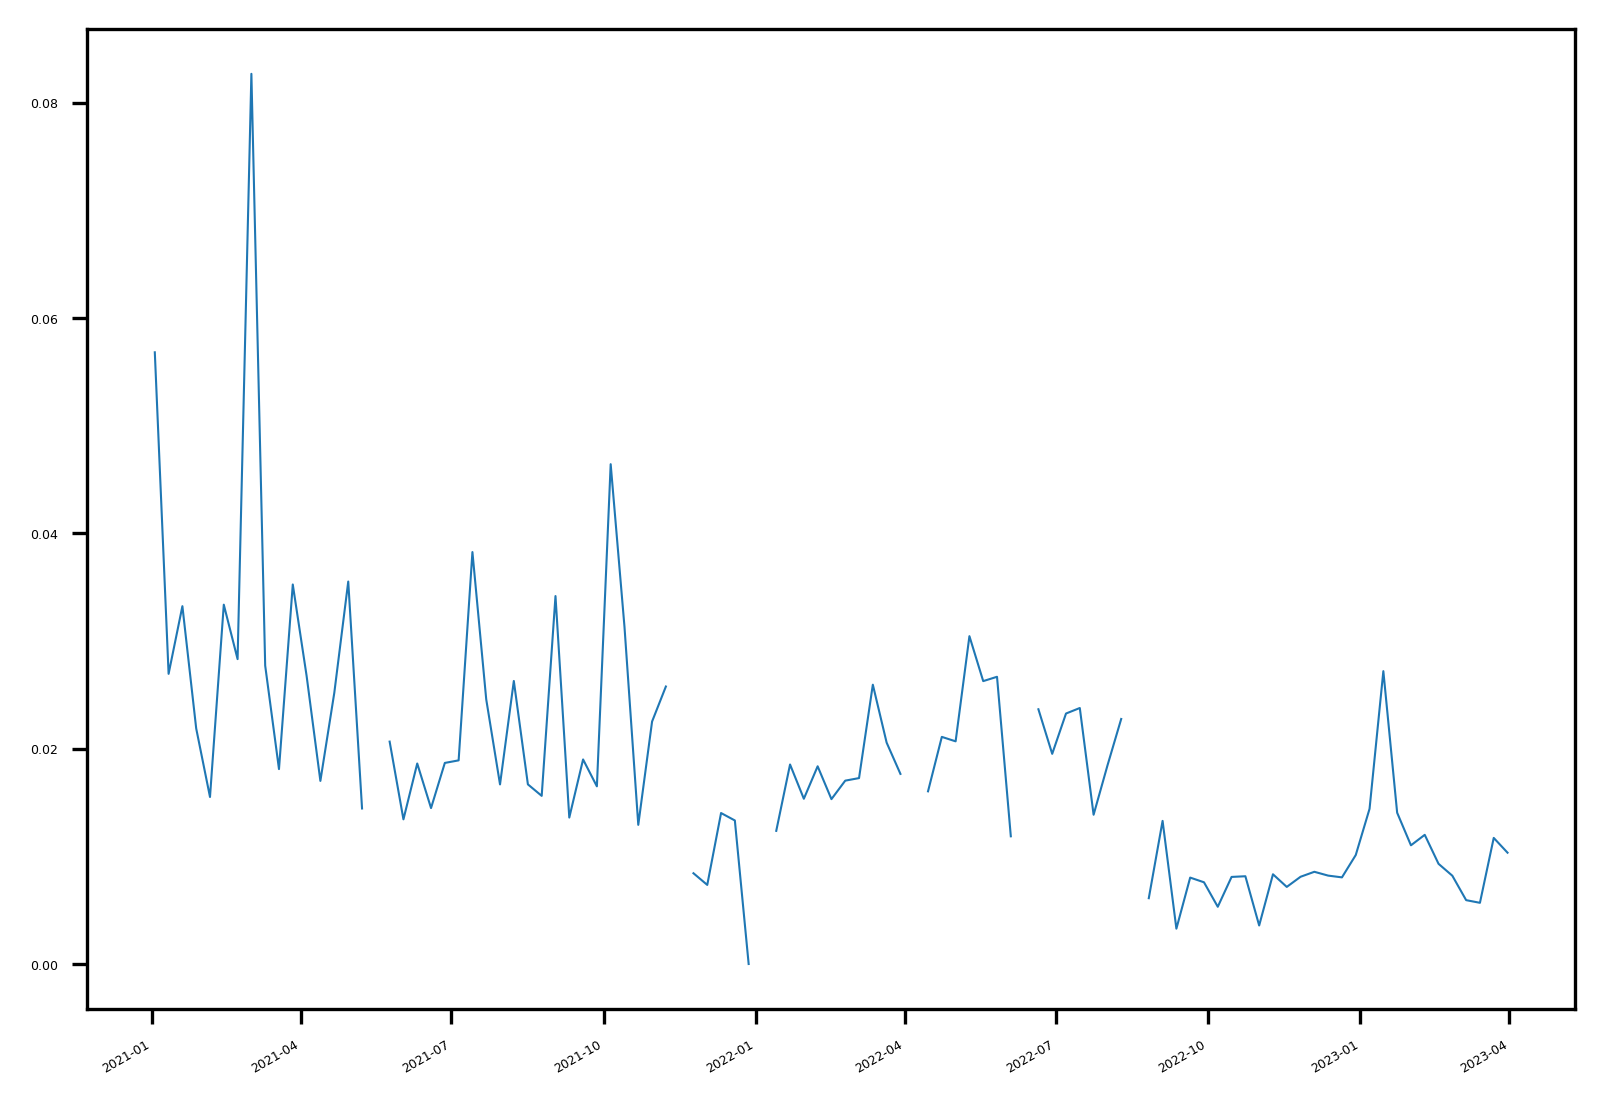

In [362]:
ddf['50%'].plot()

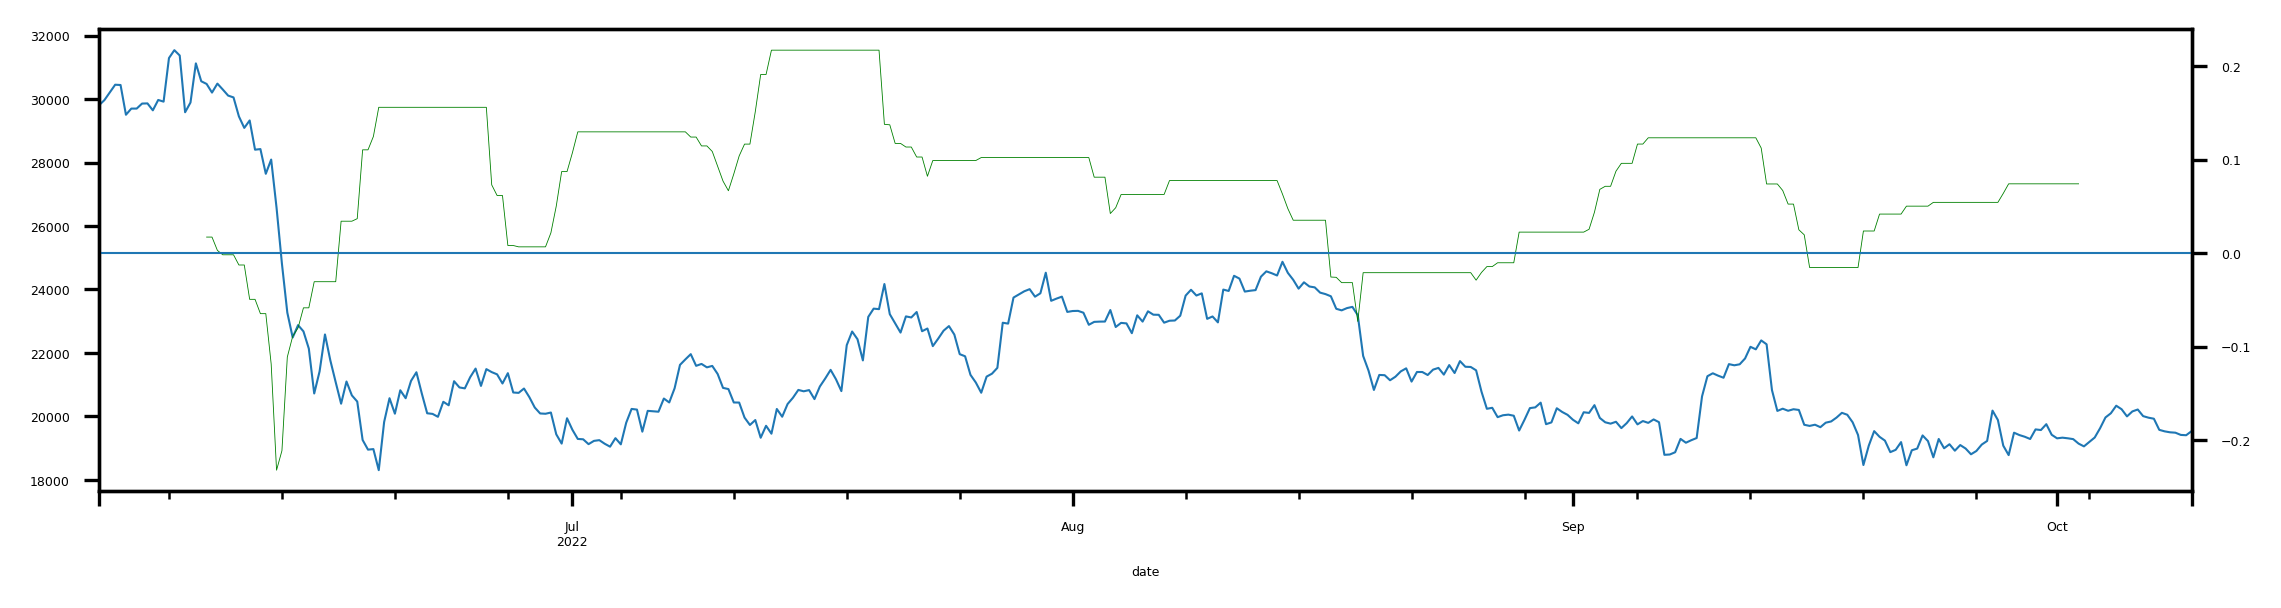

In [84]:
lag = sl_lag.value
wdf['lret'] = (wdf.close/wdf.close.shift()).apply(np.log)
wdf['flret'] = wdf.lret.rolling(window=lag).sum().rolling(lag).max().shift(-lag)

# fig, ax = plt.subplots(figsize=(9,2))
# ax2 = ax.secondary_yaxis(location='right')
wdf.close.plot(figsize=(9,2))
ax2 = wdf.flret.plot(secondary_y=True, c='g', lw=0.2)
ax2.axhline(0)


In [79]:
ax2.axhline(0)